# Wasserstein Barycenter

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.problems.linear import barycenter_problem
from ott.solvers.linear import continuous_barycenter, sinkhorn

We illustrate in this notebook how to use the {class}`~ott.solvers.linear.continuous_barycenter.FreeWassersteinBarycenter` solver to compute the {term}`Wasserstein barycenter` of either one or multiple probability distributions. We start by generating a few 2D point clouds of varying support size.

In [2]:
ns = (193, 20, 27, 5)
offsets = (
    jnp.array((3.0, 3.0)),
    jnp.array((-3.0, 3.0)),
    jnp.array((0.0, -3.0)),
    jnp.array((0.0, 5.0)),
)
d = 2
k = 10

keys = jax.random.split(jax.random.key(0), 4)

point_clouds = []
weights = []

for key, n, offset in zip(keys, ns, offsets):
    k1, k2 = jax.random.split(key)
    point_clouds.append(jax.random.normal(k1, (n, d)) + offset)
    weight = jax.random.uniform(k2, (n,))
    weight /= weight.sum()
    weights.append(weight)


flattened_points = jnp.concatenate(point_clouds, axis=0)
flattened_weights = jnp.concatenate(weights, axis=0)

A {term}`Wasserstein barycenter` problem is defined by a list of (weighted) points clouds, and a linear solver that will be used in inner iterations of the outer solver. Here we rely on the {term}`Sinkhorn algorithm` to solve those sub-problems.


In [3]:
bprob = barycenter_problem.FreeBarycenterProblem(
    y=flattened_points, b=flattened_weights, num_per_segment=ns
)

Next, we instantiate the solver that will be used to compute the barycenter, along with a few parameters needed to monitor its convergence.

In [4]:
solver = continuous_barycenter.FreeWassersteinBarycenter(
    linear_solver=sinkhorn.Sinkhorn(max_iterations=10_000),
    max_iterations=10,
    threshold=0.00001,
)

We jit the solver first and apply it to the problem above.

In [5]:
jitted_solver = jax.jit(solver, static_argnames="bar_size")
out = jitted_solver(bprob, bar_size=13)

The `out` object contains relevant information about the barycenter itself, notably
its points and how the cost evolved throughout iterations

In [6]:
print("Shape of barycenter : ", out.x.shape)
print(
    "Convergence of inner loop iterations :", out.all_linear_solvers_converged
)
print("Objective: ", out.costs_along_iterations)

Shape of barycenter :  (13, 2)
Convergence of inner loop iterations : True
Objective:  [23.27366  15.290319 15.27664  15.271326 15.267798 15.265217 15.263294
 15.261808 15.260738 15.260044]


## Visualize results

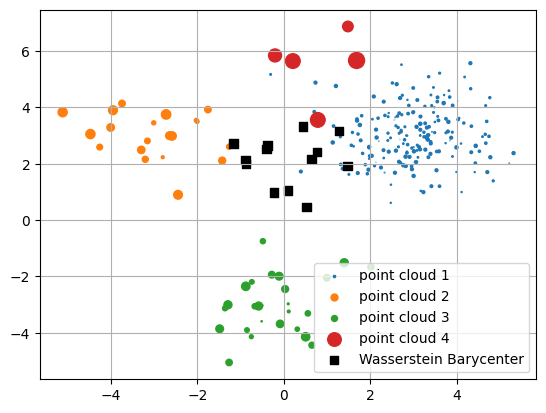

In [7]:
base_size = 500
for i, (weight, point_cloud) in enumerate(zip(weights, point_clouds)):
    plt.scatter(
        point_cloud[:, 0],
        point_cloud[:, 1],
        s=base_size * weight,
        label="point cloud " + str(i + 1),
    )
plt.scatter(
    out.x[:, 0],
    out.x[:, 1],
    s=base_size * out.a,
    c="black",
    marker="s",
    label="Wasserstein Barycenter",
)
plt.legend()
plt.grid(True)
plt.show()

Note that the {term}`Wasserstein barycenter` problem can also be instantiated on a single measure, to generate a uniformly weighted variant of the $k$-means algorithm as presented in {cite}`cuturi:14`.

In [8]:
bprob = barycenter_problem.FreeBarycenterProblem(
    y=point_clouds[0], b=weights[0], num_per_segment=(ns[0],)
)

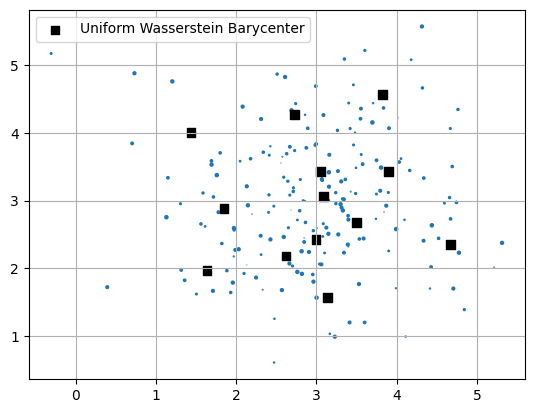

In [9]:
out = jitted_solver(bprob, bar_size=13)

plt.scatter(
    point_clouds[0][:, 0],
    point_clouds[0][:, 1],
    s=base_size * weights[0],
)
plt.scatter(
    out.x[:, 0],
    out.x[:, 1],
    s=base_size * out.a,
    c="black",
    marker="s",
    label="Uniform Wasserstein Barycenter",
)
plt.legend()
plt.grid(True)
plt.show()